In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from concurrent.futures import ThreadPoolExecutor

import rasterio as rio
from rasterio.crs import CRS

import cv2
from affine import Affine
import numpy as np

from tqdm.notebook import tqdm

Image.MAX_IMAGE_PIXELS = 933120000

In [2]:
# REFERENCE IMAGE FROM QGIS
template = Image.open(r"data\GIS\Harris_full_roadsclipped_dark_full.tiff")
# template = Image.open(r"data\GIS\template_cropped.png")

# TILE INDEX TO TEST ON
test_index = Image.open(r"data\000_WorkingFiles\HarrisIndexes\48201CIND0_0992.tif")

In [3]:
def bomb_sides(image, n, replacement_value):
    result = np.copy(image)
    rows, cols = image.shape

    # Replace values in the left and right columns
    result[:, :n] = replacement_value
    result[:, -n:] = replacement_value

    # Replace values in the top and bottom rows
    result[:n, :] = replacement_value
    result[-n:, :] = replacement_value

    return result

def preprocess_image_good(image):
    image = np.asarray(image) * 255
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.dilate(image, np.ones((3,3), np.uint8), iterations=1)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 150, image, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=2)
    image = np.where(image < 50, 0, 255).astype(np.uint8)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=5)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = 255 - image
    return image

def preprocess_image_working(image):
    image = np.asarray(image) * 255
    image = bomb_sides(image, 255, 500)
    image = image.astype(np.uint8)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = cv2.erode(image, np.ones((5,5), np.uint8), iterations=10)
    image = cv2.GaussianBlur(image, (31, 31), 0)
    image = 255 - image
    return image

def preprocess_template(template):
    template = np.asarray(template).astype(np.uint8)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # template = cv2.GaussianBlur(template, (11, 11), 0)
    # template = 255 * template / np.max(template)
    template = template.astype(np.uint8)
    template = 255 - template
    return template

template = preprocess_template(template)
test_preprocess = preprocess_image_good(test_index)
Image.fromarray(template).save("template.png")
Image.fromarray(test_preprocess).save("test.png")

In [4]:
class ReturnValues:
    def __init__(self, _result, _mask, _rotated_template, _scale, _angle):
        self.result = _result
        self.mask = _mask
        self.rotated_template = _rotated_template
        self.scale = _scale
        self.angle = _angle

def wrapPattern(scale):
    return patternMatch(test_preprocess, template, scale, 0)

def patternMatch(test_preprocess, template, scale, angle, method=cv2.TM_SQDIFF):
    # Resize the template based on the current scale
    scaled_template = cv2.resize(template, None, fx=scale, fy=scale)
    # Rotate the template based on the current angle
    rotation_matrix = cv2.getRotationMatrix2D((scaled_template.shape[1] / 2, scaled_template.shape[0] / 2), angle, 1.0)
    rotated_template = cv2.warpAffine(scaled_template, rotation_matrix, (scaled_template.shape[1], scaled_template.shape[0]))
    mask = np.where(rotated_template == 0, 0, 255).astype(np.uint8)
    # Perform template matching
    result = cv2.matchTemplate(test_preprocess, rotated_template, method, mask=mask)
    return ReturnValues(result, mask,rotated_template, scale, angle)

In [5]:
scales = np.arange(0.8, 1.01, 0.02)

# Initialize a list to store the matches
all_matches = []

# Initialize variables to store the best match
best_match_scale = 1.0
best_match_angle = 0.0

opt_max = False

if opt_max:
    best_match_value = -1 * np.inf
else:
    best_match_value = np.inf

result_list = list()
best_loc_list = list()
rect_corner_list = list()

with ThreadPoolExecutor(max_workers=4) as executor:
    for retvalue in tqdm(executor.map(wrapPattern, scales), total=len(scales)):
        
        mask = retvalue.mask
        result = retvalue.result
        rotated_template = retvalue.rotated_template
        scale = retvalue.scale
        angle = retvalue.angle
        if not opt_max:
            result = np.sqrt(result / np.count_nonzero(mask))
            
        result_list.append(result)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if opt_max:
            best_val = max_val
            best_loc = max_loc
            bottom_right = (best_loc[0] + int(rotated_template.shape[1]), best_loc[1] + int(rotated_template.shape[0]))
            
            best_loc_list.append(best_loc)
            rect_corner_list.append(bottom_right)
            
        else:
            best_val = min_val
            best_loc = min_loc
            bottom_right = (best_loc[0] + int(rotated_template.shape[1]), best_loc[1] + int(rotated_template.shape[0]))
            best_loc_list.append(best_loc)
            rect_corner_list.append(bottom_right)            
        
        print(scale, angle, best_val)

  0%|          | 0/11 [00:00<?, ?it/s]

0.8 0 127.10752047488349
0.8200000000000001 0 127.09981015617319
0.8400000000000001 0 127.0527288133111
0.8600000000000001 0 126.94744542159758
0.8800000000000001 0 127.0170686967541
0.9000000000000001 0 127.13275329192847
0.9200000000000002 0 127.50856237735566
0.9400000000000002 0 127.5483261778528
0.9600000000000002 0 127.65922748405818
0.9800000000000002 0 127.73412461637817
1.0000000000000002 0 127.81095693785873


In [7]:
elem_list = [x.flatten() for x in result_list]
elem_list = np.hstack(elem_list)

if opt_max:
    thresh = np.percentile(elem_list, 99.9)
    loc_list = [x > thresh for x in result_list]
else:
    thresh = np.percentile(elem_list, 0.1)
    loc_list = [x < thresh for x in result_list]

votes = np.array([np.count_nonzero(x) for x in loc_list])
rescale_factor = np.sum(votes * scales) / np.sum(votes)

x_list = np.hstack([np.where(x)[0] for x in loc_list])
y_list = np.hstack([np.where(x)[1] for x in loc_list])

x = int(np.median(x_list))
y = int(np.median(y_list))

br = (int(y + template.shape[1] * rescale_factor), int(x + template.shape[0] * rescale_factor))

In [9]:
three_band = np.dstack([test_preprocess,test_preprocess,test_preprocess])
print(three_band.shape)

# Draw rectangles around the matched regions for each scale
for i in range(len(best_loc_list)):
    top_left = best_loc_list[i]
    bottom_right = rect_corner_list[i]
    cv2.rectangle(three_band, top_left, bottom_right, (255, 0, 0), 10)
    
# _ = cv2.rectangle(three_band, best_match_loc, best_match_br, (0, 0, 255), 5)
_ = cv2.rectangle(three_band, (y, x), br, (0, 255, 0), 5)

(10200, 14840, 3)


In [10]:
rescale_factor

0.8627819548872182

In [11]:
cv2.imwrite('testout.png', three_band)

True

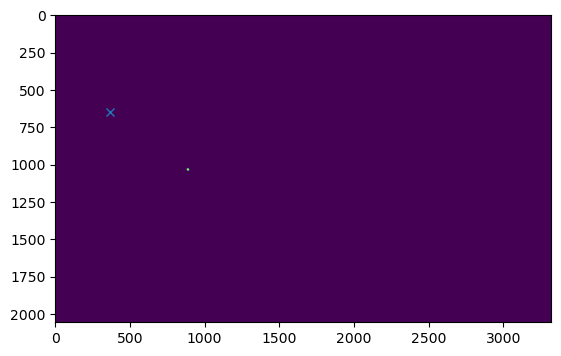

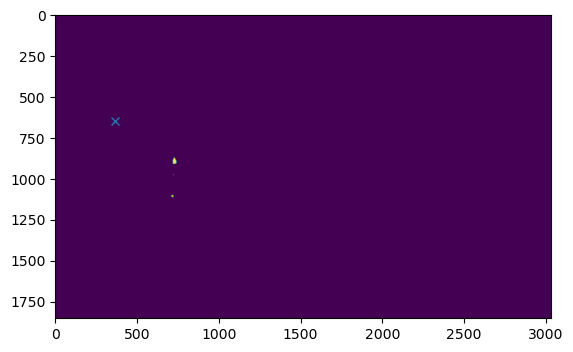

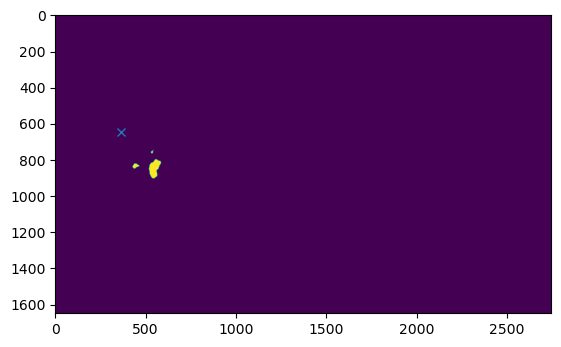

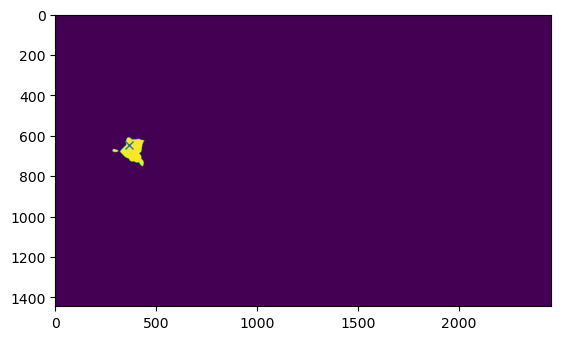

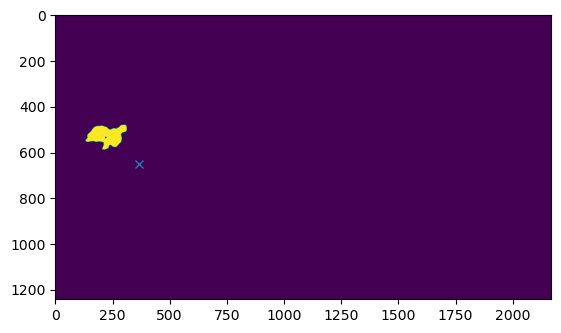

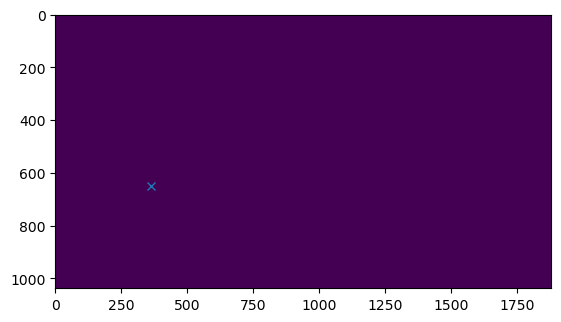

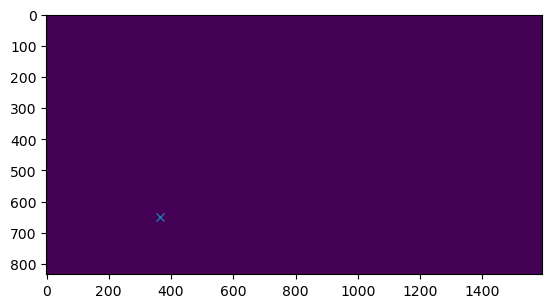

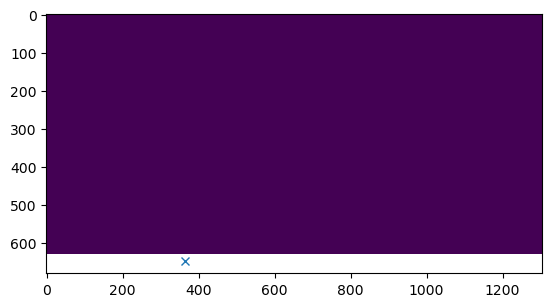

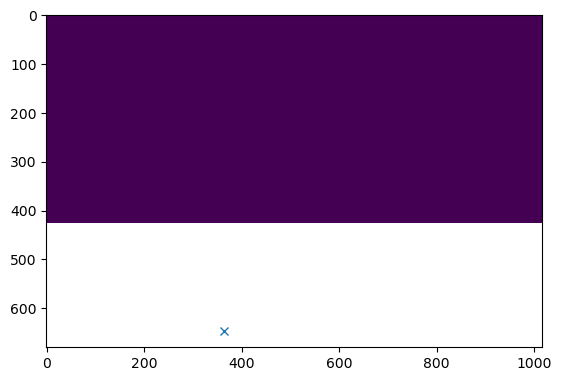

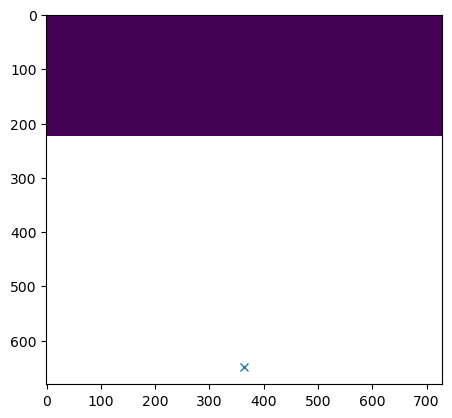

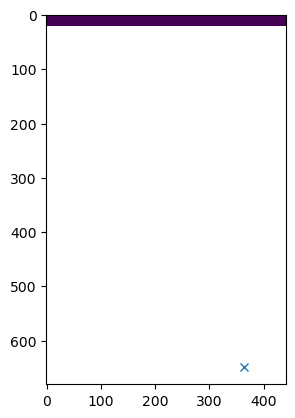

In [12]:
for i in loc_list:
    fig, ax = plt.subplots()
    ax.imshow(i)
    ax.plot(y, x, 'x')
    plt.show()